In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Import data
train = datasets.get_mnist('balanced')
test = datasets.get_mnist('balanced', train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 12
nu = 0.0001
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'act_bi_lipschitzian'

In [4]:
# Initialize dimensions, models, parameters and optimizers
dims = [M, 835, 835, len(train.classes)]

model_kwargs = {
    'device': device
}

nets = {
    "ReLU": models.dense.AdjointDense(dims, activation=nn.ReLU, **model_kwargs),
    "ELU": models.dense.AdjointDense(dims, activation=nn.ELU, **model_kwargs),
    "CELU": models.dense.AdjointDense(dims, activation=nn.CELU, activation_params={'alpha':0.5}, **model_kwargs),
    "BiReLU": models.dense.AdjointDense(dims, activation=modules.BiReLU, **model_kwargs),
    "BiELU": models.dense.AdjointDense(dims, activation=modules.BiELU, **model_kwargs),
    "BiCELU": models.dense.AdjointDense(dims, activation=modules.BiCELU, **model_kwargs),
}

# Initialize with same parameters
for k, model in nets.items():
    loss_trace[k] = {}
    if k != 'ReLU':
        nets[k].net.V.weight.data = nets['ReLU'].net.V.weight.data.clone()
        nets[k].net.W1.weight.data = nets['ReLU'].net.W1.weight.data.clone()
        nets[k].net.U.weight.data = nets['ReLU'].net.U.weight.data.clone()
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)
    

In [5]:
# Define objective function

def objective_function(x, xh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.binary_cross_entropy_with_logits(xh, x, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params ReLU    :  1392827
No. params ELU     :  1392827
No. params CELU    :  1392827
No. params BiReLU  :  1392827
No. params BiELU   :  1392827
No. params BiCELU  :  1392827


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float() / 255
xs = xims.flatten(-2, -1).to(device)
xt = torch.tensor(test.data).float().flatten(-2, -1).to(device) / 255

index_matrix = torch.eye(len(train.classes)).to(device)
yt = index_matrix[test.targets]

In [8]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        y = index_matrix[_y]
        xhs = {}
        ldicts = {}
        
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            yh = nets[cur](x)

            # Calculate loss
            loss, ldicts[cur] = objective_function(y, yh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yht = nets[cur](xt)
                ldicts[cur]['lt'] = F.binary_cross_entropy_with_logits(yht, yt, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            clear_output(wait=True)
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    print(utils.reporting.generate_report(cur, e, i, ldicts[cur]))
            
        i += 1

m ReLU       e   11 i   3500 lx 9.421E-03 l 9.421E-03 lt 1.616E-02 
m ELU        e   11 i   3500 lx 1.143E-02 l 1.143E-02 lt 1.741E-02 
m CELU       e   11 i   3500 lx 1.043E-02 l 1.043E-02 lt 1.668E-02 
m BiReLU     e   11 i   3500 lx 1.091E-02 l 1.091E-02 lt 1.768E-02 
m BiELU      e   11 i   3500 lx 1.148E-02 l 1.148E-02 lt 1.911E-02 
m BiCELU     e   11 i   3500 lx 1.059E-02 l 1.059E-02 lt 1.786E-02 


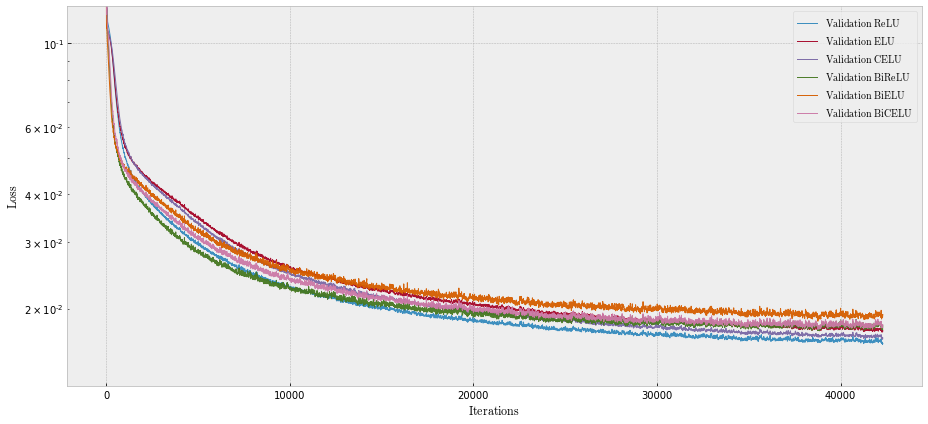

In [9]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["lt"], linewidth=1, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.ylim(0.0125, 0.125)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

In [10]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [11]:
# Calculate relative error on test data
test_tensor = torch.tensor(test.data.astype(float) / 255).flatten(-2, -1).float()

print(f"Relative Error:")
for k, model in nets.items():
    yth = model(test_tensor)
    yt_sigmoid = torch.sigmoid(yth).cpu()
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(yt.cpu(), yt_sigmoid, reduction='mean'):4E} " +
        f"BCE {F.binary_cross_entropy_with_logits(yth, yt.cpu(), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(yt_sigmoid, yt.cpu(), reduction='mean'):4E} " +
        f"Acc {utils.metrics.top_k_accuracy(yth, yt, k=1):4E} " +
        f"Ac5 {utils.metrics.top_k_accuracy(yth, yt):4E} "
    )

Relative Error:
ReLU  : RE 2.746351E-01 BCE 1.621767E-02 MSE 4.386474E-03 Acc 8.634043E-01 Ac5 9.882447E-01 
ELU   : RE 2.999650E-01 BCE 1.754431E-02 MSE 4.777093E-03 Acc 8.532447E-01 Ac5 9.868617E-01 
CELU  : RE 2.873904E-01 BCE 1.675530E-02 MSE 4.566040E-03 Acc 8.592553E-01 Ac5 9.883510E-01 
BiReLU: RE 2.938296E-01 BCE 1.803241E-02 MSE 4.809743E-03 Acc 8.523936E-01 Ac5 9.868617E-01 
BiELU : RE 3.176633E-01 BCE 1.928802E-02 MSE 5.160856E-03 Acc 8.446277E-01 Ac5 9.843085E-01 
BiCELU: RE 2.993421E-01 BCE 1.815174E-02 MSE 4.856517E-03 Acc 8.515958E-01 Ac5 9.865957E-01 


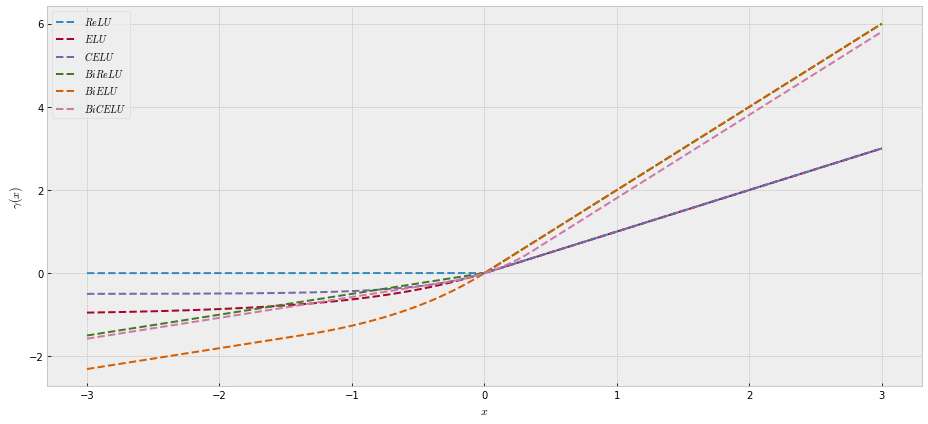

In [12]:
linspace = torch.linspace(-3, 3, 5000)

for cur, net in nets.items():
    plt.plot(linspace, net.net.gamma0(linspace), '--', label=f"${cur}$")

plt.xlabel('$x$')
plt.ylabel('$\gamma(x)$')
plt.legend();
plt.savefig(f'../figures/misc/{experiment_name}_functions.pdf');

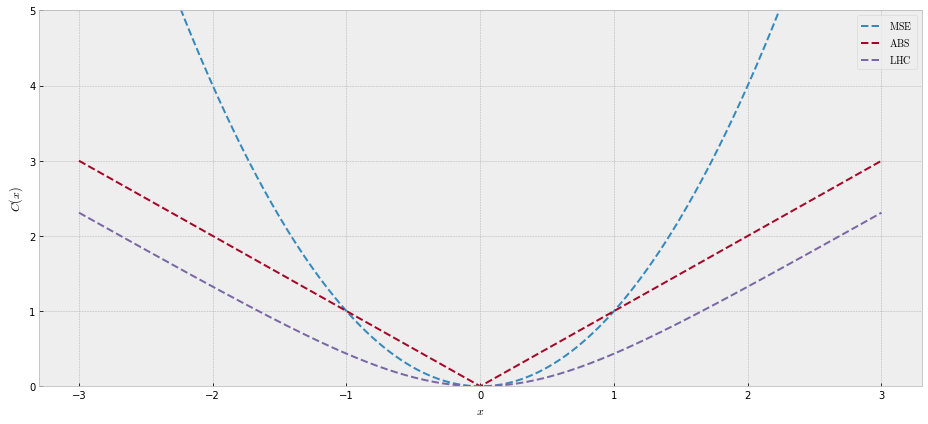

In [13]:
plt.plot(linspace, linspace**2, '--', label='$\mathrm{MSE}$')
plt.plot(linspace, torch.abs(linspace), '--', label='$\mathrm{ABS}$')
plt.plot(linspace, torch.log(torch.cosh(linspace)), '--', label='$\mathrm{LHC}$')
plt.ylim(0, 5)
plt.xlabel('$x$')
plt.ylabel('$C(x)$')
plt.legend();
plt.savefig(f'../figures/misc/MSE_ABS_LHC.pdf');

In [14]:
# Compute Estimated Generalized Inverses
Ids = {}
for k, model in nets.items():
    with torch.no_grad():
        dct = model.get_weight_dict()
        Ids[k] = dct['V.T'] @ dct['U.T'] @ dct['U'] @ dct['V']

# Note: Moore-Penrose Pseudoinverse is calculated using test data
#       which has fewer (18800) observations than training (112800)
Ids['PIn'] = torch.pinverse(test_tensor) @ test_tensor

In [15]:
# Relative error to Identity
print("Relative Error w.r.t. Identity (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(torch.eye(M), I, 'fro')}")

Relative Error w.r.t. Identity (Frobenius Norm):
ReLU    : 8.95763874053955
ELU     : 2.992413282394409
CELU    : 7.59039306640625
BiReLU  : 2.0968234539031982
BiELU   : 1.189727544784546
BiCELU  : 1.5692821741104126
PIn     : 0.5413821935653687


In [16]:
print("Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(test_tensor, test_tensor @ I, 'fro'):.6f}")

Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):
ReLU    : 37.581215
ELU     : 9.754519
CELU    : 67.148392
BiReLU  : 14.023952
BiELU   : 4.065254
BiCELU  : 7.434107
PIn     : 0.000071


In [17]:
# Calculate condition numbers
print("Condition Numbers:")
for i, (k, I) in enumerate(Ids.items()):
    kappa = torch.linalg.cond(I)
    print(f'{k:8} {kappa.item():5E}')

Condition Numbers:
ReLU     7.780514E+07
ELU      8.106453E+07
CELU     1.679803E+08
BiReLU   1.011891E+08
BiELU    1.020262E+08
BiCELU   9.446916E+07
PIn      2.398625E+08


In [18]:
# Calculate approximate Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        utils.metrics.stochastic_spectral_norm(w, 8) 
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:8} {lipschitz_product.item():5E}')

Lipschitz Constants:
ReLU     1.407931E+05
ELU      3.588385E+05
CELU     2.001812E+05
BiReLU   1.802032E+04
BiELU    1.360570E+04
BiCELU   1.857331E+04


In [19]:
# Calculate actual Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        torch.svd(w)[1][0]
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)

    # To account for activation, we need to multiply by the Lipschitz constants
    if k not in ['ReLU', 'ELU', 'CELU']:
        lipschitz_product *= 4
    
    print(f'{k:8} {lipschitz_product.item():5E}')

Lipschitz Constants:
ReLU     1.572254E+05
ELU      3.592566E+05
CELU     2.059529E+05
BiReLU   7.580736E+04
BiELU    6.073292E+04
BiCELU   7.968972E+04


/tmp/ipykernel_1806898/2827801945.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  linspace = torch.linspace(-3, 3)


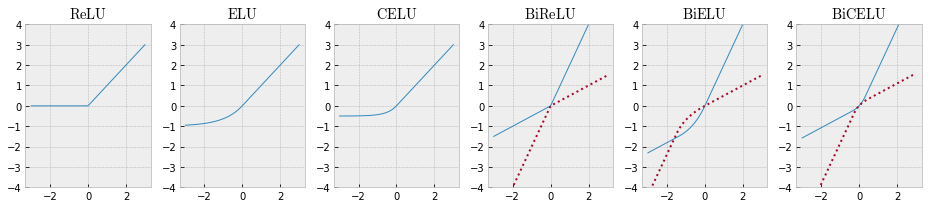

In [20]:
linspace = torch.linspace(-3, 3, 5000)

fig, ax = plt.subplots(1, len(nets), figsize=(13,3))

for i, (cur, net) in enumerate(nets.items()):
    ax[i].plot(linspace, net.net.gamma0(linspace), linewidth=1, label=f"$\gamma$")    
    if cur not in ['ReLU', 'ELU', 'CELU']:
        ax[i].plot(linspace, net.net.gamma0.T(linspace), ':', label=f"$\gamma^{{-1}}$")
    ax[i].set(ylim=(-4,4), title=f'$\mathrm{{{cur}}}$')


plt.savefig(f'../figures/misc/{experiment_name}_functions.pdf');

In [21]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [22]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.binary_cross_entropy_with_logits(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

In [23]:
# Training loop

for e in range(2):
    i = 0
    for x, _y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        y = index_matrix[_y]
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            yh = nets[cur](x)
            ye = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(ye, yh)

            loss.backward()
            opts_p[cur].step()
            
            # Validation
            with torch.no_grad():
                yht = nets[cur](xt)
                yhte = nets[cur](xt + r)
                ldicts[cur]['lt'] = F.binary_cross_entropy_with_logits(yht, yt, reduction='mean')
                ldicts[cur]['lte'] = F.binary_cross_entropy_with_logits(yhte, yt, reduction='mean')

        # Plot and Report
        if i % 50 == 0:
            clear_output(wait=True)
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    print(utils.reporting.generate_report(cur, e, i, ldicts[cur]))
            
        i += 1

m ReLU       e    1 i   3500 lphi 2.600E+02 lt 1.622E-02 lte 1.879E-02 
m ELU        e    1 i   3500 lphi 1.991E+02 lt 1.754E-02 lte 2.181E-02 
m CELU       e    1 i   3500 lphi 2.121E+02 lt 1.676E-02 lte 2.108E-02 
m BiReLU     e    1 i   3500 lphi 2.098E+02 lt 1.803E-02 lte 5.301E-02 
m BiELU      e    1 i   3500 lphi 1.817E+02 lt 1.929E-02 lte 6.581E-02 
m BiCELU     e    1 i   3500 lphi 1.913E+02 lt 1.815E-02 lte 1.009E-01 


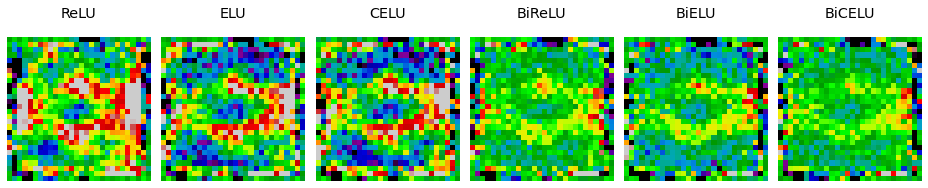

In [24]:
fig, ax = plt.subplots(1, len(nets))
for i, (k, r) in enumerate(rs.items()):
    ax[i].matshow(r.to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [25]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model(test_tensor + r)
    XH = model(test_tensor)

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
ReLU  : 0.193596 0.098739 7.892931
ELU   : 0.158443 0.098739 6.459728
CELU  : 0.167312 0.098739 6.821331
BiReLU: 0.319301 0.098739 13.017914
BiELU : 0.275244 0.098739 11.221718
BiCELU: 0.380219 0.098739 15.501536


In [26]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Calculate estimated Jacobian from test data
# NOTE: This process can take upwards of 10 minutes
no_cond = 1000
_x = test_tensor.clone()[:no_cond].to(device)
_x.requires_grad = True
Js = {}
for k, model in nets.items():
    Js[k] = torch.zeros(no_cond, len(train.classes), M)
    for i in tqdm(range(no_cond)):
        model.zero_grad()
        Js[k][i] = torch.autograd.functional.jacobian(
            lambda x: model(x),
            _x[i]
    ).cpu()

# Move models to CPU
for k in nets:
    nets[k] = nets[k].to('cpu')

# Move samples to CPU
_x = _x.to('cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
print("Jacobian Relative Condition Numbers (Frobenius Norm):")
for k, J in Js.items():
    _xh = nets[k](_x)
    rel = torch.mean(torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    Jnorm = torch.mean(torch.linalg.norm(J, dim=(1,2)))
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2)) / (torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    )
    print(f"{k:8} den: {rel:.6E} abs_cond: {Jnorm:.6E} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (Frobenius Norm):
ReLU     den: 1.137528E+01 abs_cond: 8.161079E+01 rel_cond: 7.339834E+00
ELU      den: 9.949716E+00 abs_cond: 6.461568E+01 rel_cond: 6.606880E+00
CELU     den: 1.026691E+01 abs_cond: 6.723003E+01 rel_cond: 6.680323E+00
BiReLU   den: 1.107982E+01 abs_cond: 1.077812E+02 rel_cond: 9.952124E+00
BiELU    den: 1.004173E+01 abs_cond: 7.778381E+01 rel_cond: 7.879111E+00
BiCELU   den: 1.094365E+01 abs_cond: 1.010648E+02 rel_cond: 9.434390E+00


In [28]:
print("Jacobian Relative Condition Numbers (L2 Norm):")
for k, J in Js.items():
    _xh = nets[k](_x)
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2), ord=2) / (torch.linalg.norm(_xh, dim=1, ord=2) / torch.linalg.norm(_x, dim=1, ord=2))
    )
    print(f"{k:3} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (L2 Norm):
ReLU rel_cond: 4.411586E+00
ELU rel_cond: 3.747230E+00
CELU rel_cond: 3.848416E+00
BiReLU rel_cond: 5.333410E+00
BiELU rel_cond: 4.096110E+00
BiCELU rel_cond: 5.392823E+00


In [29]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [30]:
# Save weights

export_weights = {}
for k in nets:
    export_weights[k] = nets[k].get_weight_dict()
    for l in export_weights[k]:
        export_weights[k][l] = export_weights[k][l].detach().numpy().tolist()

with open(f'{serialized_path}weights.pickle', 'wb') as outfile:
    pickle.dump(export_weights, outfile)

In [31]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)